In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Load the data
url_metadata  = "https://raw.githubusercontent.com/Lemurlover/hackbio-cancer-internship/main/data/TCGA_COAD_metadata.csv"
metadata = pd.read_csv(url_metadata)



In [4]:
print(metadata.columns)

Index(['Barcode', 'tumor_type', 'sample_type', 'tissue_type', 'gender',
       'pathologic_stage', 'tumor_stage'],
      dtype='object')


In [7]:
url_normdata = "https://raw.githubusercontent.com/Lemurlover/hackbio-cancer-internship/main/data/normalized_data.csv"
gene_expression = pd.read_csv(url_normdata)

print(metadata.columns)
print(gene_expression.columns)

Index(['Barcode', 'tumor_type', 'sample_type', 'tissue_type', 'gender',
       'pathologic_stage', 'tumor_stage'],
      dtype='object')
Index(['Unnamed: 0', 'TCGA-AA-3692-01A-01R-0905-07',
       'TCGA-AA-A00L-01A-01R-A002-07', 'TCGA-G4-6625-01A-21R-1774-07',
       'TCGA-AA-3522-01A-01R-0821-07', 'TCGA-CM-4750-01A-01R-1410-07',
       'TCGA-AA-3554-01A-01R-0826-07', 'TCGA-AA-3561-01A-01R-0821-07',
       'TCGA-G4-6307-01A-11R-1723-07', 'TCGA-A6-6781-01A-22R-A278-07',
       ...
       'TCGA-A6-2680-11A-01R-A32Z-07', 'TCGA-A6-5667-11A-01R-1723-07',
       'TCGA-AA-3520-11A-01R-A32Z-07', 'TCGA-AZ-6605-11A-01R-1839-07',
       'TCGA-AA-3489-11A-01R-1839-07', 'TCGA-AA-3534-11A-01R-A32Z-07',
       'TCGA-A6-2685-11A-01R-A32Z-07', 'TCGA-AA-3527-11A-01R-A32Z-07',
       'TCGA-AA-3697-11A-01R-1723-07', 'TCGA-AA-3712-11A-01R-1723-07'],
      dtype='object', length=523)


In [9]:
# 2. Prepare data for ML
# Set the sample_id as the index for metadata
metadata.set_index('Barcode', inplace=True)

In [10]:
# Ensure the sample IDs match between gene expression and metadata
common_samples = gene_expression.columns.intersection(metadata.index)

# Subset both datasets to include only common samples
gene_expression = gene_expression[common_samples]
metadata = metadata.loc[common_samples]


Sample Type Distribution:
sample_type
Primary Tumor          481
Solid Tissue Normal     41
Name: count, dtype: int64

Pathologic Stage Distribution:
pathologic_stage
Stage IIA     154
Stage I        84
Stage IIIB     64
Stage IV       54
Stage IIIC     46
Stage II       41
Stage III      22
Stage IVA      18
Stage IIB      13
Stage IIIA      8
Stage IVB       2
Stage IIC       1
Stage IA        1
Name: count, dtype: int64


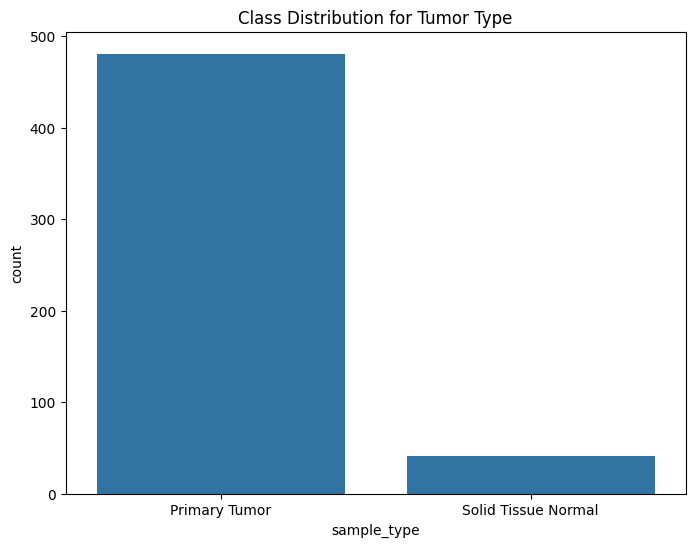

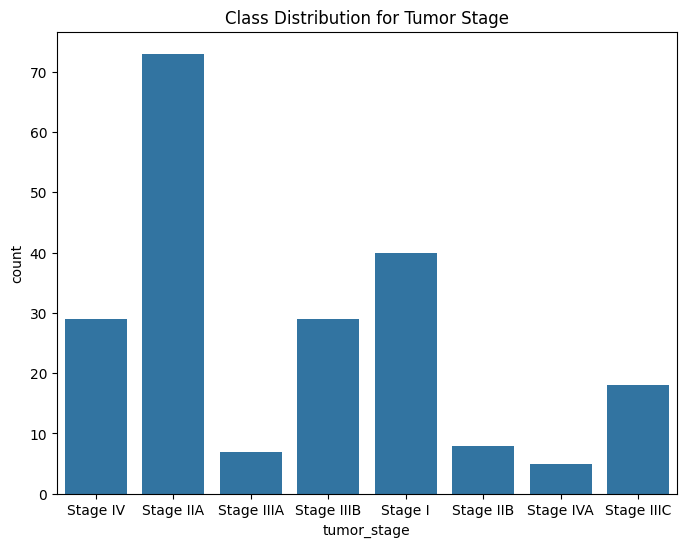

In [14]:
# CHECK DATA IF BALANCED OR IMBALANCED
# Check the distribution of cancer diagnosis and stage
print("\nSample Type Distribution:")
print(metadata['sample_type'].value_counts())
print("\nPathologic Stage Distribution:")
print(metadata['pathologic_stage'].value_counts())



# Optionally, plot class distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.countplot(x='sample_type', data=metadata)
plt.title("Class Distribution for Tumor Type")
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x='tumor_stage', data=metadata)
plt.title("Class Distribution for Tumor Stage")
plt.show()



A-CANCER DIAGNOSIS

In [ ]:
 # Features and target variables for cancer diagnosis

# Using "sample_type" as the target
X = gene_expression.T # Transpose to have samples as rows and genes as columns
y_diagnosis = metadata['sample_type'] # Target labels

# Split data into training and test sets (80% training, 20% testing)
X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X, y_diagnosis, test_size=0.2, random_state=42, stratify=y_diagnosis)




A1-RANDOM FOREST MODEL WITH RFE

In [ ]:
# Create RandomForest model
rf = RandomForestClassifier(n_estimators=500, random_state=42)

# Recursive Feature Elimination (RFE) to select important features
rfe = RFE(estimator=rf, n_features_to_select=50, step=1)  # Select top 50 features
rfe.fit(X_train_diag, y_train_diag)

# Transform the training and test data to the selected features
X_train_diag_rfe = rfe.transform(X_train_diag)
X_test_diag_rfe = rfe.transform(X_test_diag)

# Fit the RandomForest model on the reduced features
rf.fit(X_train_diag_rfe, y_train_diag)

# Make predictions
rf_pred_diag = rf.predict(X_test_diag_rfe)

# Evaluation
print("Random Forest Results for Cancer Diagnosis:")
print(confusion_matrix(y_test_diag, rf_pred_diag))
print(classification_report(y_test_diag, rf_pred_diag))

# Display selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)


A2-kNN with variance threshold

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Scaling features for kNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_diag)
X_test_scaled = scaler.transform(X_test_diag)

# Perform PCA to capture a threshold variance (e.g., 95%)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create kNN model
knn = KNeighborsClassifier()

# Grid search to find the best k
params = {'n_neighbors': range(3, 10)}
knn_model = GridSearchCV(knn, params, cv=5)
knn_model.fit(X_train_pca, y_train_diag)

# Make predictions
knn_pred_diag = knn_model.predict(X_test_pca)

# Evaluation
print("kNN Results for Cancer Diagnosis:")
print(confusion_matrix(y_test_diag, knn_pred_diag))
print(classification_report(y_test_diag, knn_pred_diag))

# Best k value
print("Best k for kNN:", knn_model.best_params_)


B-CANCER CLASSIFICATION

In [ ]:
# Features and target variables for cancer stage classification
X = gene_expression.T # Transpose to have samples as rows and genes as columns
y_stage = data['tumor_stage']  # Target for cancer stage classification

# Split data into train and test for both diagnosis and stage classification
from sklearn.model_selection import train_test_split

# Split for diagnosis
X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X, y_diagnosis, test_size=0.2, random_state=42, stratify=y_diagnosis)

# Split for stage classification
X_train_stage, X_test_stage, y_train_stage, y_test_stage = train_test_split(X, y_stage, test_size=0.2, random_state=42, stratify=y_stage)